# Performance Benchmarking for KV Drive

#### The goal of these set of experiments is to characterize the variability across platforms in a systematic and consistent way in terms of KV drive. The steps of experiments are as follows,

- Run Stress-ng benchmarks on **one KV drive**;
- Run Stress-ng benchmarks on machine **issdm-6**, and get the "**without limit**" result;
- Find all the **common benchmarks** from both results;
- Calculate the **speedup (normalized value)** of each benchmark based on the one from KV drive (**issdm-6 (without limit) / KV drive**);
- Use **[torpor](https://github.com/ivotron/torpor)** to calculate the best **cpu quota** by minimizing the average speedups. We will later use this parameter to limit the cpu usage in the docker container;
- Run Stress-ng benchmarks in the **constrained docker container** on machine **issdm-6**, and get the "**with limit**" result;
- Calculate the **speedup** based on KV drive again (**issdm-6 (with limit) / KV drive**), then we get a new "**speedup range**", which should be must smaller than the previous one.
- Run a bunch of other benchmarks on both KV drive and constrained docker container to **verify** if they are all within in the later "**speedup range**".
- Make conclusion.

In [1]:
%matplotlib inline
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

pd.set_option("display.max_rows", 8)

First, we load all test data.

In [46]:
df = pd.read_csv('stress-ng/third/calibration/results/alltests.csv')

Let's have a look at the pattern of data.

In [47]:
df.head()

,machine,limits,benchmark,class,lower_is_better,repetition,result
0,issdm-6,without,stressng-cpu-all,cpu,False,1,73.245089
1,issdm-6,without,stressng-cpu-ackermann,cpu,False,1,7.410952
2,issdm-6,without,stressng-cpu-bitops,cpu,False,1,1291.771327
3,issdm-6,without,stressng-cpu-callfunc,cpu,False,1,176485.829385
4,issdm-6,without,stressng-cpu-cdouble,cpu,False,1,2326.402108


Show all the test machines.

In [48]:
df['machine'].unique()

array(['issdm-6', 'kv3'], dtype=object)

Define a predicate for machine **issdm-6**

In [49]:
machine_is_issdm_6 = df['machine'] == 'issdm-6'

The number of benchmarks we ran on **issdm-6** with limit is

In [50]:
limits_is_with = df['limits'] == 'with'
df_issdm_6_with_limit = df[machine_is_issdm_6 & limits_is_with]
len(df_issdm_6_with_limit)

126

The number of benchmarks we ran on **issdm-6** without limit is

In [51]:
limits_is_without = df['limits'] == 'without'
len(df[machine_is_issdm_6 & limits_is_without])

128

The number of benchmarks we ran on **kv3**

In [52]:
df_kv3 = df[df['machine'] == 'kv3']
len(df_kv3)

123

Because some benchmarks could fail druing the test suite running, those **failed tests** are not in the result report. We want to know how many common tests they **both complated**.

In [53]:
df_common = pd.merge(df_issdm_6_with_limit, df_kv3, how='inner', on='benchmark')
len(df_common)

120

Read the normalized results.

In [55]:
df = pd.read_csv('stress-ng/third/calibration/results/alltests_with_normalized_results_1.0.csv')

Show some of the data lines. The normalized value is the speedup based on **kv3**. It becomes a negative value when the benchmark runs on **issdm-6** is slower than on **kv3** (slowdown).

In [56]:
df.head()

,benchmark,base_result,machine,limits,class,lower_is_better,repetition,result,normalized
0,stressng-cpu-all,0.559459,issdm-6,without,cpu,False,1,73.245089,130.921281
1,stressng-cpu-all,0.559459,issdm-6,with,cpu,False,1,5.229076,9.346665
2,stressng-cpu-ackermann,1.352526,issdm-6,without,cpu,False,1,7.410952,5.479342
3,stressng-cpu-ackermann,1.352526,issdm-6,with,cpu,False,1,0.535738,-2.524603
4,stressng-cpu-bitops,535.492536,issdm-6,without,cpu,False,1,1291.771327,2.412305


There is one benchmark not present in both **with** and **without** limit result set.

In [57]:
len(df) / 2

120.5

Since the number of common benchmarks is **113**, we wnat to find the one benchmark less than **two** results (all from **issdm-6**).

In [58]:
grouped = df.groupby('benchmark')
df[grouped['benchmark'].transform(len) < 2]

,benchmark,base_result,machine,limits,class,lower_is_better,repetition,result,normalized
230,stressng-memory-oom-pipe,0.099849,issdm-6,without,memory,False,1,0.087546,-1.140532


In other words, **stressng-memory-oom-pipe** should not in the **with limit results of issdm-6**

In [59]:
df_issdm_6_with_limit[df_issdm_6_with_limit['benchmark'] == 'stressng-memory-oom-pipe'].empty

True

We can find the number of benchmarks are **speed-up** and the number of them are **slowdown** on **without** limit results.

In [60]:
predicate_without_limits = df['limits'] == 'without'
predicate = predicate_without_limits & (df['normalized'] >= 0)
len(df[predicate])

116

In [61]:
predicate = predicate_without_limits & (df['normalized'] < 0)
len(df[predicate])

5

All right, let's draw a bar plot for all results.

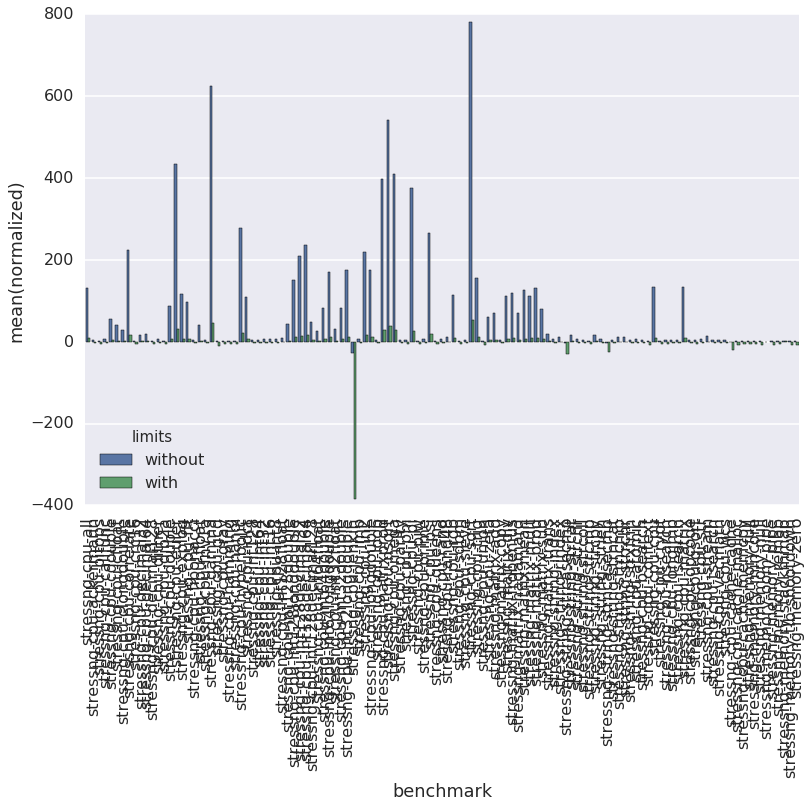

In [62]:
sns.set()
sns.set_context("poster")
plt.xticks(rotation=90)
sns.barplot(x='benchmark', y='normalized', hue='limits', data=df)

Which one have the **greatest** and **smallest** speedup on **without limit** banchmark results?

In [65]:
df_without_sorted = df[df['limits'] == 'without'].sort_values(by='normalized', ascending=0)
head_without = df_without_sorted.head()
tail_without = df_without_sorted.tail()
head_without.append(tail_without)

,benchmark,base_result,machine,limits,class,lower_is_better,repetition,result,normalized
130,stressng-cpu-sqrt,5.172518,issdm-6,without,cpu,False,1,4041.087860,781.261246
42,stressng-cpu-gamma,0.196768,issdm-6,without,cpu,False,1,122.810914,624.140683
102,stressng-cpu-nsqrt,0.170864,issdm-6,without,cpu,False,1,92.667529,542.346714
30,stressng-cpu-euler,8422.503460,issdm-6,without,cpu,False,1,3668571.085120,435.567774
...,...,...,...,...,...,...,...,...,...
218,stressng-cpu-cache-cache,32.907173,issdm-6,without,cpu-cache,False,1,22.300178,-1.475646
176,stressng-string-strncasecmp,11272.022718,issdm-6,without,string,False,1,6306.289926,-1.787425
162,stressng-string-strcasecmp,13468.776467,issdm-6,without,string,False,1,6318.336606,-2.131697
90,stressng-cpu-jenkin,470339.193258,issdm-6,without,cpu,False,1,17101.863912,-27.502218


Let's have a look at the **speedup frequency** on **without limit** benchmark results.

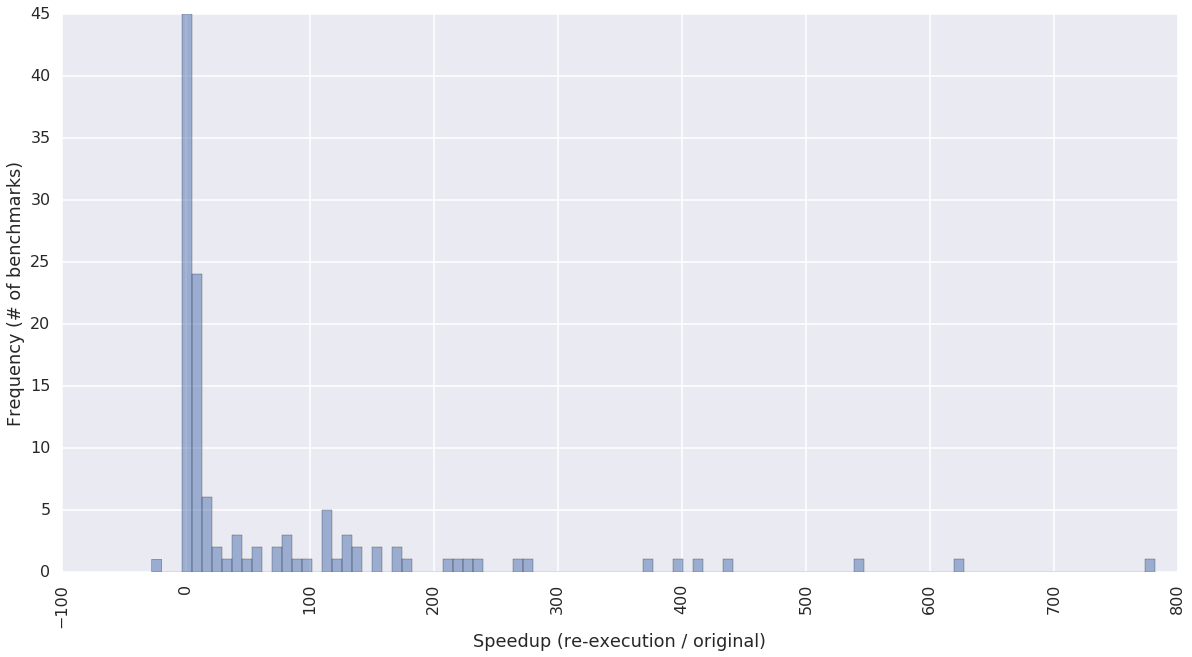

In [66]:
ax = df[df['limits'] == 'without'].groupby('limits').normalized.hist(bins=100,xrot=90,figsize=(20,10),alpha=0.5)
plt.xlabel('Speedup (re-execution / original)')
plt.ylabel('Frequency (# of benchmarks)')

Which one have the **greatest** and **smallest** speedup on **with limit** benchmark results?

In [67]:
df_with_sorted = df[df['limits'] == 'with'].sort_values(by='normalized', ascending=0)
head_with = df_with_sorted.head()
tail_with = df_with_sorted.tail()
head_with.append(tail_with)

,benchmark,base_result,machine,limits,class,lower_is_better,repetition,result,normalized
131,stressng-cpu-sqrt,5.172518,issdm-6,with,cpu,False,1,280.696748,54.266945
43,stressng-cpu-gamma,0.196768,issdm-6,with,cpu,False,1,8.898357,45.222582
103,stressng-cpu-nsqrt,0.170864,issdm-6,with,cpu,False,1,6.699748,39.210998
31,stressng-cpu-euler,8422.503460,issdm-6,with,cpu,False,1,263206.984608,31.250445
...,...,...,...,...,...,...,...,...,...
219,stressng-cpu-cache-cache,32.907173,issdm-6,with,cpu-cache,False,1,1.600015,-20.566790
177,stressng-string-strncasecmp,11272.022718,issdm-6,with,string,False,1,449.198875,-25.093613
163,stressng-string-strcasecmp,13468.776467,issdm-6,with,string,False,1,458.204632,-29.394675
91,stressng-cpu-jenkin,470339.193258,issdm-6,with,cpu,False,1,1227.934894,-383.032680


The **average speedup** of **with limit** benchmarks is,

In [68]:
df[df['limits'] == 'with']['normalized'].mean()

-1.0929740153897114

Let's have a look at the **speedup frequency** on **with limit** benchmark results.

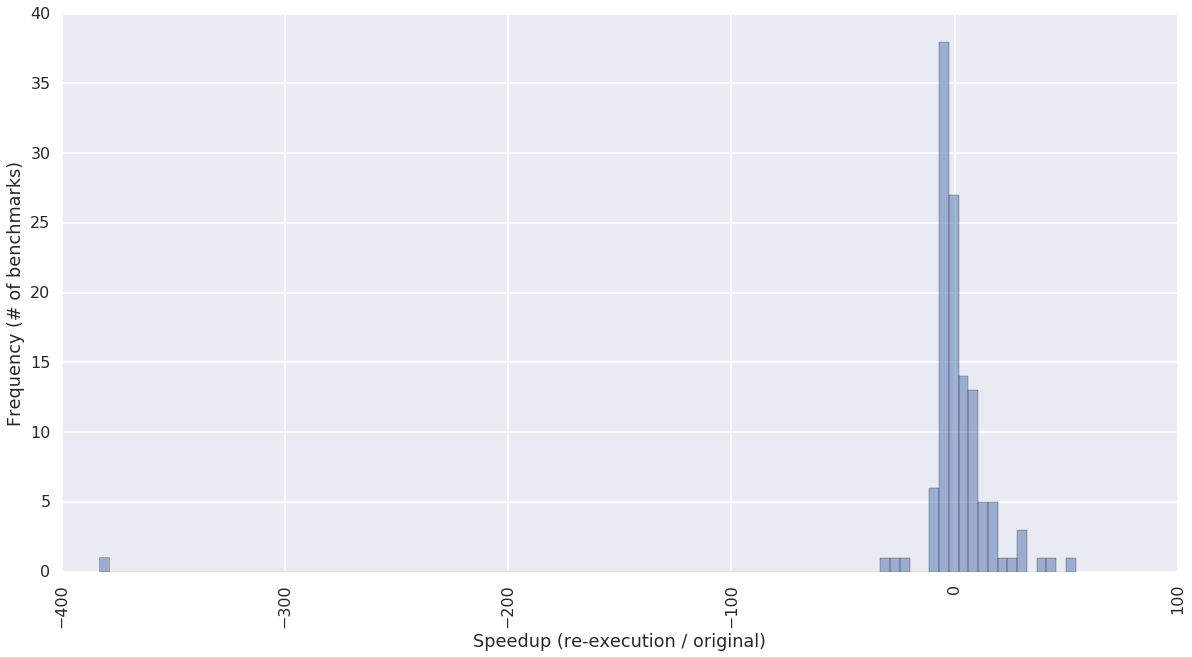

In [69]:
ax = df[df['limits'] == 'with'].groupby('limits').normalized.hist(bins=100,xrot=90,figsize=(20,10),alpha=0.5)
plt.xlabel('Speedup (re-execution / original)')
plt.ylabel('Frequency (# of benchmarks)')

The **stressng-cpu-jenkin** benchmark is a collection of (non-cryptographic) hash functions for multi-byte keys. See [Jenkins hash function](https://en.wikipedia.org/wiki/Jenkins_hash_function) from Wikipedia for more details.

We got the speedup boundary **from -383.032680 to 54.266945** by using parameters **--cpuset-cpus=1 --cpu-quota=7234 --cpu-period=100000**, which means the docker container only uses **7.234ms CPU worth of run-time every 100ms on cpu 1** (See [cpu](https://access.redhat.com/documentation/en-US/Red_Hat_Enterprise_Linux/6/html/Resource_Management_Guide/sec-cpu.html) for more details).

Now we use **9** other benchmark programs to verify this result. These programs are,
- **blogbench**: filesystem benchmark.
- **compilebench**: It tries to age a filesystem by simulating some of the disk IO common in creating, compiling, patching, stating and reading kernel trees.
- **fhourstones**: This integer benchmark solves positions in the game of connect-4.
- **himeno**: Himeno benchmark score is affected by the performance of a computer, especially memory band width. This benchmark program takes measurements to proceed major loops in solving the Poisson’s equation solution using the Jacobi iteration method.
- **interbench**: It is designed to measure the effect of changes in Linux kernel design or system configuration changes such as cpu, I/O scheduler and filesystem changes and options.
- **nbench**: NBench([Wikipedia](https://en.wikipedia.org/wiki/NBench)) is a synthetic computing benchmark program developed in the mid-1990s by the now defunct BYTE magazine intended to measure a computer's CPU, FPU, and Memory System speed.
- **pybench**: It is a collection of tests that provides a standardized way to measure the performance of Python implementations.
- **ramsmp**: RAMspeed is a free open source command line utility to measure cache and memory performance of computer systems.
- **stockfish-7**: It is a simple benchmark by letting Stockfish analyze a set of positions for a given limit each.

Read verification tests data.

In [23]:
df = pd.read_csv('verification/alltests_with_normalized_results_1.0.csv')

Show number of test benchmarks.

In [24]:
len(df)

93

Let's see the speedup of each individual result.

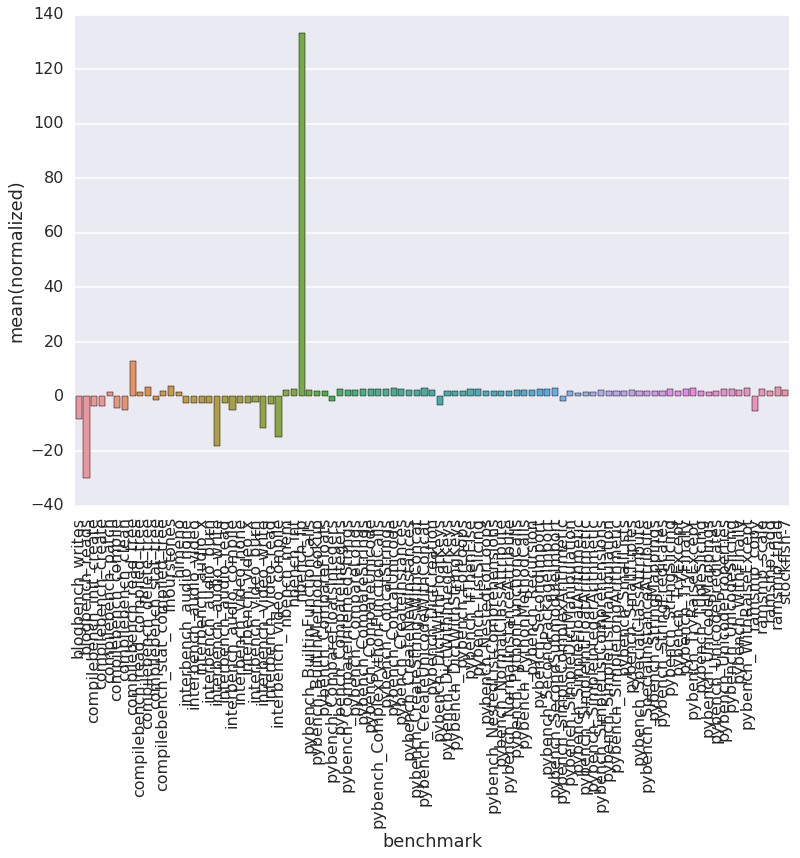

In [25]:
sns.set()
sns.set_context("poster")
plt.xticks(rotation=90)
sns.barplot(x='benchmark', y='normalized', data=df)

Sort the test results set by the **absolute value of normalized**

In [26]:
df.reindex(df.normalized.abs().sort_values(ascending=0).index).head(8)

,benchmark,base_result,lower_is_better,result,normalized
29,nbench_fp,0.165,False,21.959,133.084848
1,blogbench_reads,271351.000,False,9113.000,-29.776254
18,interbench_audio_write,275.000,True,15.000,-18.333333
26,interbench_video_compile,165.000,True,11.000,-15.000000
7,compilebench_read_tree,0.840,False,10.950,13.035714
24,interbench_video_write,116.000,True,10.000,-11.600000
0,blogbench_writes,464.000,False,55.000,-8.436364
88,ramsmp_copy,1289.030,False,245.050,-5.260273


See the histogram of all of speedups after **filtering out the one outlier**.

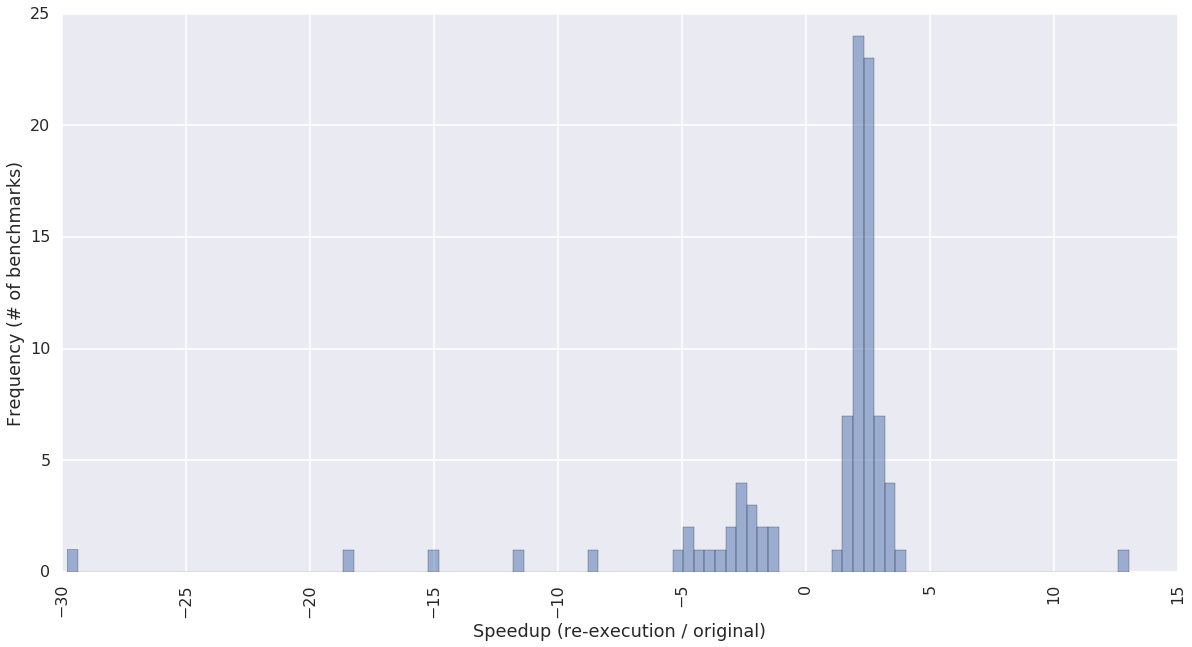

In [27]:
df_t = df[df['benchmark'] != 'nbench_fp']
ax = df_t.normalized.hist(bins=100,xrot=90,figsize=(20,10),alpha=0.5)
plt.xlabel('Speedup (re-execution / original)')
plt.ylabel('Frequency (# of benchmarks)')

The **average of speedup** of the **test benchmarks** without the one outlier is,

In [28]:
df_t['normalized'].mean()

0.37300988620902487

**Conclusion: ** Except the **nbench_fp**, all the 92 benchmarks fall within our predicted speedup range **[-276.278268, 127.716328]**, and most of them (86) are in **[-6, 4]**, which has the length of variety **8** (=10-2, becuase there won't be any speedup sit in (-1, 1)).

**Question: ** Is it an acceptable emulational environment for the KV drive?